In [15]:
using CSV, DataFrames, Gadfly, Distributions, SparseArrays, LinearAlgebra

include("iGMRF.jl");
include("dataGen.jl");
include("gibbs.jl");

# Création de la grille à 9 cellules

Chaque cellule est représentée par un triplet $[\mu, \sigma, \xi]$ indiquant les vraie valeur des paramètres de la GEV à déterminer.

In [16]:
# Seed
Random.seed!(400)
# Dimensions de la grille
m₁ = 6;
m₂ = 6;
# Nb total de cellules
m = m₁ * m₂
# Insuffisance de rang de la matrice de structure
r = 1;
# Hyperparamètres
κᵤ = 100.0;
# Matrice de structure
F = iGMRF(m₁, m₂, κᵤ);

In [17]:
grid_target = generateTargetGrid(F);

In [18]:
grid_target[:, :, 1]

6×6 Matrix{Float64}:
  0.150578     0.125958   -0.00443581   0.0419361    0.000996108  -0.0601342
  0.213952     0.0870288   0.0466061   -0.0489566   -0.0310282    -0.0398228
  0.144839     0.0709377   0.0674184   -0.0783321   -0.0460267    -0.157605
 -0.00832208   0.0660304   0.084337    -0.00656615  -0.137013     -0.108068
  0.0790171    0.120558    0.0679903   -0.114431    -0.0765482    -0.0770912
  0.120752    -0.0833394   0.00551236  -0.0666542   -0.170395     -0.179677

# Génération de données

Le but est de générer des données sur chaque cellule à partir des paramètres de la GEV de la grille cible.

In [19]:
nobs = 1000
data = generateData(grid_target, nobs);

# Modèle 

In [20]:
include("gibbs.jl");

niter = 10000
δ² = 0.07
κᵤ₀ = 10
μ₀ = zeros(m)

κᵤ, μ = gibbs(niter, data, m₁=m₁, m₂=m₂, δ²=δ², κᵤ₀=κᵤ₀, μ₀=μ₀);

θ = vcat(reshape(κᵤ, 1, niter), μ)

μ = θ[2:end, :];
κᵤ = θ[1, :];

μ̂ = mean(θ[2:end, :], dims=2);
κ̂ᵤ = mean(θ[1, :]);

Taux d'acceptation μ1: 43.7 %
Taux d'acceptation μ2: 43.59 %
Taux d'acceptation μ3: 42.99 %
Taux d'acceptation μ4: 43.28 %
Taux d'acceptation μ5: 43.33 %
Taux d'acceptation μ6: 43.62 %
Taux d'acceptation μ7: 42.9 %
Taux d'acceptation μ8: 41.21 %
Taux d'acceptation μ9: 42.11 %
Taux d'acceptation μ10: 41.7 %
Taux d'acceptation μ11: 41.62 %
Taux d'acceptation μ12: 43.9 %
Taux d'acceptation μ13: 42.97 %
Taux d'acceptation μ14: 42.73 %
Taux d'acceptation μ15: 42.63 %
Taux d'acceptation μ16: 42.45 %
Taux d'acceptation μ17: 42.21 %
Taux d'acceptation μ18: 43.03 %
Taux d'acceptation μ19: 43.36 %
Taux d'acceptation μ20: 42.21 %
Taux d'acceptation μ21: 42.55 %
Taux d'acceptation μ22: 42.06 %
Taux d'acceptation μ23: 42.09 %
Taux d'acceptation μ24: 42.71 %
Taux d'acceptation μ25: 43.57 %
Taux d'acceptation μ26: 41.21 %
Taux d'acceptation μ27: 41.98 %
Taux d'acceptation μ28: 42.53 %
Taux d'acceptation μ29: 41.69 %
Taux d'acceptation μ30: 43.14 %
Taux d'acceptation μ31: 43.85 %
Taux d'acceptation μ3

In [22]:
reshape(μ̂, m₁, m₂)

6×6 Matrix{Float64}:
  0.13873      0.16102     0.13048    -0.00711347   0.0625512   0.0911598
  0.0912815    0.0778336   0.0827764   0.0829059    0.100654   -0.0667048
  0.0140348    0.0178032   0.0787886   0.110861     0.0706331   0.0305063
  0.0331565   -0.0254805  -0.0513591  -0.0306864   -0.0921299  -0.0599137
 -0.00871683  -0.0742533  -0.0461959  -0.106738    -0.0544566  -0.181882
 -0.0581194   -0.0833626  -0.169485   -0.170299    -0.0935864  -0.179851

In [23]:
grid_target[:, :, 1]

6×6 Matrix{Float64}:
  0.150578     0.125958   -0.00443581   0.0419361    0.000996108  -0.0601342
  0.213952     0.0870288   0.0466061   -0.0489566   -0.0310282    -0.0398228
  0.144839     0.0709377   0.0674184   -0.0783321   -0.0460267    -0.157605
 -0.00832208   0.0660304   0.084337    -0.00656615  -0.137013     -0.108068
  0.0790171    0.120558    0.0679903   -0.114431    -0.0765482    -0.0770912
  0.120752    -0.0833394   0.00551236  -0.0666542   -0.170395     -0.179677

Distance entre les deux matrices

In [24]:
norm(reshape(μ̂, m₁, m₂) .- grid_target[:, :, 1], 2) / m

0.017309360773052607

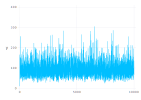

In [25]:
plot(y=κᵤ, Geom.line)

In [26]:
mean(κᵤ)

92.37190315861467

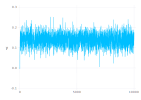

In [27]:
plot(y=μ[1, :], Geom.line)

In [28]:
using Mamba

sim = Chains(
    copy(θ'), 
    names=[
        "κᵤ", 
        "μ1",
        "μ2", 
        "μ3", 
        "μ4", 
        "μ5", 
        "μ6", 
        "μ7", 
        "μ8", 
        "μ9",
        "μ10",
        "μ11", 
        "μ12", 
        "μ13", 
        "μ14", 
        "μ15", 
        "μ16", 
        "μ17", 
        "μ18",
        "μ19",
        "μ20", 
        "μ21", 
        "μ22", 
        "μ23", 
        "μ24", 
        "μ25", 
        "μ26", 
        "μ27",
        "μ28",
        "μ29", 
        "μ30", 
        "μ31", 
        "μ32", 
        "μ33", 
        "μ34", 
        "μ35", 
        "μ36"
    ]
);

summarystats(sim)

         Mean          SD         Naive SE        MCSE        ESS   
 κᵤ 92.3719031586 32.334635280 0.32334635280 0.79502111477 1654.1642
 μ1  0.1387297812  0.029927450 0.00029927450 0.00064493817 2153.2936
 μ2  0.0912814930  0.028665133 0.00028665133 0.00061292077 2187.2542
 μ3  0.0140347588  0.028844552 0.00028844552 0.00065025859 1967.6843
 μ4  0.0331564701  0.028113744 0.00028113744 0.00059863435 2205.5357
 μ5 -0.0087168318  0.028202708 0.00028202708 0.00055717096 2562.1508
 μ6 -0.0581194071  0.029768148 0.00029768148 0.00063216805 2217.3720
 μ7  0.1610203700  0.029118611 0.00029118611 0.00058081457 2513.4272
 μ8  0.0778336432  0.027281988 0.00027281988 0.00055030113 2457.8264
 μ9  0.0178031764  0.027681826 0.00027681826 0.00057433572 2323.0460
μ10 -0.0254804575  0.026896773 0.00026896773 0.00062198353 1870.0043
μ11 -0.0742533299  0.027438375 0.00027438375 0.00055317399 2460.3294
μ12 -0.0833626155  0.028442806 0.00028442806 0.00059665730 2272.4533
μ13  0.1304799321  0.028800836 0.0